## Mobile Games A/B Testing - Cookie Cats

##### Project Goal
Trying to use A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

In [1]:
# import packages and read the dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro, levene, mannwhitneyu

dataset=pd.read_csv("cookie_cats.csv")
dataset=pd.DataFrame(dataset)
df=dataset.copy()
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### Dataset Overview

In [2]:
print('Data size is',df.shape)

Data size is (90189, 5)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# userid is not a number, so I change it to object in the dataset
df['userid']=df['userid'].astype(object)

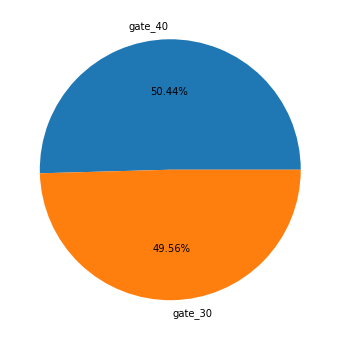

In [5]:
# Compare the Number of players in two groups; show in a pie chart.
group=pd.value_counts(df['version'])
plt.figure(figsize=(6,6))
plt.pie(group,labels= group.index ,autopct='%.2f%%')
plt.show()

In [6]:
# show the statistical information of column sum_gamerounds
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,5.0,16.0,51.0,49854.0


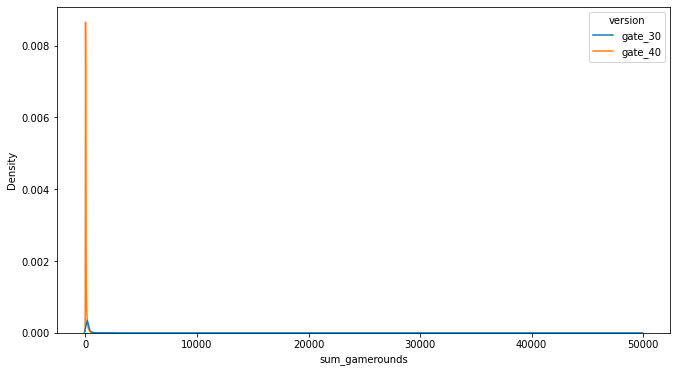

In [7]:
# Draw a single density plot of column sum_gamerounds by different group
plt.figure(figsize=(11,6))
sns.kdeplot(x = 'sum_gamerounds' , data = df , hue = 'version')
plt.show()

In [8]:
# From above figure, it shows a high frequence close to 0 gameround. 
df[df['sum_gamerounds'] == 0]

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False
...,...,...,...,...,...
90067,9986185,gate_30,0,False,False
90093,9988600,gate_40,0,False,False
90116,9990773,gate_30,0,False,False
90147,9994604,gate_30,0,False,False


In [9]:
# To see the precentage of 0 game round in the dataset
print(f'The percentage of installing the game and never playing it is {round(len(df[df.sum_gamerounds == 0]) / len(df) , 4) * 100} %')

The percentage of installing the game and never playing it is 4.43 %


<function matplotlib.pyplot.show(close=None, block=None)>

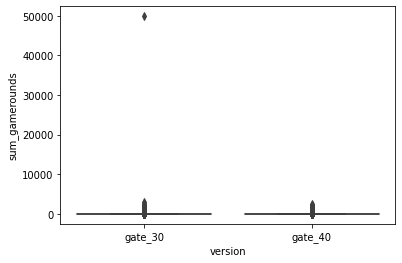

In [10]:
# plot boxplot for value sum_gamerounds
sns.boxplot(data=df,x='version',y='sum_gamerounds')
plt.show

In [11]:
# Clearly, there are outlier in gate_30. I am going to remove the outlier from the dataset.
df=df[df['sum_gamerounds'] != max(df['sum_gamerounds'])]

In [12]:
pd.pivot_table(df,'sum_gamerounds','version',aggfunc=[np.mean,max,'count'])

,mean,max,count
,sum_gamerounds,sum_gamerounds,sum_gamerounds
version,,,
gate_30,51.342111,2961,44699
gate_40,51.298776,2640,45489


In [13]:
# Want to see the precentage of player come back and play the game in 1 day and 7 day after they install the app.
df.groupby('version').agg({"userid":"count", "retention_1":"mean","retention_7":"mean"})

,userid,retention_1,retention_7
version,,,
gate_30,44699,0.448198,0.190183
gate_40,45489,0.442283,0.182000


### AB Test
The control group is the plyer who assigned to gate_30. The experiment group is the plyer who assigned to gate_40.

In [14]:
cont=df[df['version']=='gate_30'].reset_index().copy()
exp=df[df['version']=='gate_40'].reset_index().copy()

cont.retention_1 = cont.retention_1.replace({True: 1, False: 0})
cont.retention_7 = cont.retention_7.replace({True: 1, False: 0})
exp.retention_1 = exp.retention_1.replace({True: 1, False: 0})
exp.retention_7 = exp.retention_7.replace({True: 1, False: 0})

In [15]:
from scipy import stats as st
def AB_testing(A, B):
    A_bar = np.mean(A)
    A_var = np.var(A)
    n1 = len(A)
    
    B_bar = np.mean(B)
    B_var = np.var(B)
    n2 = len(B)
    
    z_score = (A_bar - B_bar) / np.sqrt((A_var / n1) + (B_var / n2))
    p_value = st.norm.cdf(z_score)
    if z_score > 0:
        p_value = 2*(1 - p_value)
    else:
        p_value = 2 * p_value
    return print(f'z-score : {z_score} , p-value : {p_value}')

In [16]:
# H0: w1=w2 ; same mean of retention_1 for two groups
# H1: w1!=w2
AB_testing(cont['retention_1'],exp['retention_1'])

z-score : 1.787114623538925 , p-value : 0.07391896442691603


We can not reject the null hypothesis at the level of 1 days retention, because the p-value is lager than alpha = 0.05.

In [17]:
# H0: w1=w2 ; same mean of retention_7 for two groups
# H1: w1!=w2
AB_testing(cont['retention_7'],exp['retention_7'])

z-score : 3.157115501031721 , p-value : 0.0015933821914237978


There is sufficient evidence to declare a difference in the average 7 days retention for the two groups, As the p-value is less than alpha = 0.05 we can reject the null hypothesis at the level of 7 days retention.

In [18]:
# Shapiro-Wilk Test
# Tests the conformity of the data to the normal distribution
# H0:Data have a normal distribution
# H1:Data do not have a normal distribution
 
test_stat1, pvalue1 = shapiro(cont['sum_gamerounds'])
test_stat2, pvalue2 = shapiro(exp['sum_gamerounds'])
print("gate30: Test Stat = %.4f, p-value = %.4f" % (test_stat1, pvalue1))
print("gate40: Test Stat = %.4f, p-value = %.4f" % (test_stat2, pvalue2))

gate30: Test Stat = 0.4886, p-value = 0.0000
gate40: Test Stat = 0.4826, p-value = 0.0000


C:\Users\nian\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In both cases, p-value = 0. The normality assumption was rejected because it was less than 0.05.

In [19]:
# Levene's Test 
# Tests whether the variances of the groups are homogeneous
# H0:groups are homogeneous
# H1:groups are not homogeneous

test_stat3, pvalue3 = levene(cont['sum_gamerounds'],exp['sum_gamerounds'])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat3, pvalue3))

Test Stat = 0.0751, p-value = 0.7840


In this case, p-value = 0.7840. Groups are homogeneous because it was lager than 0.05.

In [20]:
# Apply Mann-Whitney U Test
test_stat4, pvalue4 = mannwhitneyu(cont['sum_gamerounds'],exp['sum_gamerounds'])
print("Test Stat = %.4f, p-value = %.4f" % (test_stat4, pvalue4))

Test Stat = 1024285761.5000, p-value = 0.0509


H0 cannot be rejected because the p-value is greater than 0.05.
That is, there is no statistically significant difference between 'gate30' and 'gate40' with 95% confidence. Therefore, the result came about by chance.

### Conclusion

Percentage of returning players of control group after 7 day is 19.0%, whereas Percentage of returning players of experimental group is 18.2%. 

The initially found percentages show that movement of gate to the 40th level affects negatively on numbers of returning players after 7 days.

By using the Mann-Whitney U Test, it shows ni statistically sifnificant difference between two groups. 

So we suggest keeping the gate at level 30.